# ENGR-E 533: Deep Learning Systems
## Homework 1

### Khandokar Md. Nayem (knayem@iu.edu)
### Mar 7, 2018

### Import necessary files and set environment parameters
My assigned Node is `r-006` and GPU `1`.

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import tensorflow as tf
import numpy as np
from operator import itemgetter
import time
import heapq
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

### Importing MNIST dataset

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
NUM_ITERATION = 1000 # Number of iteration number in Train
TRAIN_BATCH_SIZE = 1000 # Sample 1000 Train batch
TEST_BATCH_SIZE = 1000 # Sample 1000 Test batch

### Xavier Initialization of Weights
These are the weight initialization function used in defining model.

In [4]:
def weight_variable (shape):
    initial = tf.truncated_normal(shape, stddev = np.sqrt(2.0/sum(shape)) )
    return tf.Variable(initial)

def bias_variable (shape):
    initial = tf.truncated_normal(shape, stddev = np.sqrt(1.0/sum(shape)) )
    return tf.Variable(initial)

### Create the fully connected model 

In [5]:
x = tf.placeholder(tf.float32, [None, 784]) 

W_1 = weight_variable([784, 1024])
b_1 = bias_variable([1024])

W_2 = weight_variable([1024, 1024])
b_2 = bias_variable([1024])

W_3 = weight_variable([1024, 1024])
b_3 = bias_variable([1024])

W_4 = weight_variable([1024, 1024])
b_4 = bias_variable([1024])

W_5 = weight_variable([1024, 10])
b_5 = bias_variable([10])




# Layer connections and Activation functions
y_1 = tf.nn.relu(tf.matmul(x, W_1) + b_1)
y_2 = tf.nn.relu(tf.matmul(y_1, W_2) + b_2)
y_3 = tf.nn.relu(tf.matmul(y_2, W_3) + b_3)
y_4 = tf.nn.relu(tf.matmul(y_3, W_4) + b_4)
y = tf.matmul(y_4, W_5) + b_5 # predicted

y_ = tf.placeholder(tf.float32, [None, 10]) # original

# Define loss and optimizer
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=y))
train_step = tf.train.AdamOptimizer().minimize(cross_entropy)

### Run the model (Q1, Q2)
On average, `Accuracy` on test batch is over `98%`. If we increase the number of iteration (Line 10, currently 1000), `Accuracy` increases; but more time is needed to train.

In [6]:
# Configuration to control GPU use
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.33
sess = tf.InteractiveSession(config=config)

tf.global_variables_initializer().run()


# Train Model
for _ in range(NUM_ITERATION):
    batch_xs, batch_ys = mnist.train.next_batch(TRAIN_BATCH_SIZE)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

    
# Test trained model
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print("Accuracy:",sess.run(accuracy, feed_dict={x: mnist.test.images,
                                      y_: mnist.test.labels}))

Accuracy: 0.9808


### Last (5th) Layer vizualization (Q3)

<IPython.core.display.Javascript object>


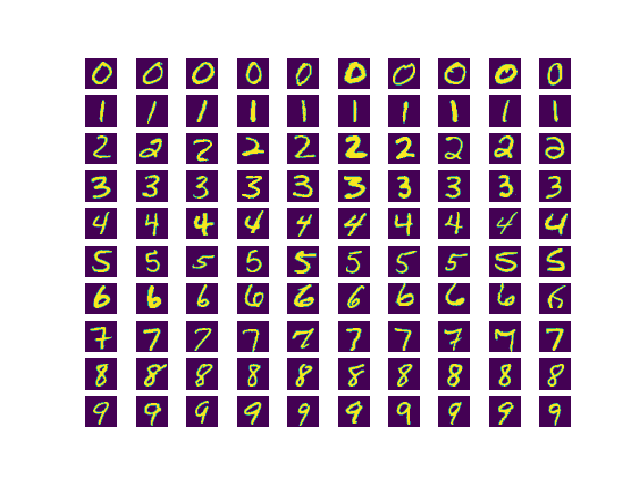

In [7]:
y_est = tf.nn.softmax(y)

batch_xs, batch_ys = mnist.test.next_batch(TEST_BATCH_SIZE)
# y_np -> last layer output
# y_np4 -> 4th layer output
y_np,y_np4=sess.run([y_est,y_4], feed_dict={x: batch_xs})
# y_np,y_np4=sess.run([y_est,y_4], feed_dict={x: mnist.test.images[:TEST_BATCH_SIZE,]})


# For 10 images for 10 classes
class_dict = dict()
for c in range(10):
    class_dict[c]=[]

# For image predicted class (image_index, probability)
for r in range(y_np.shape[0]):
    key = np.argmax(y_np[r])
    class_dict[key].append( (r, np.amax(y_np[r]) ) )
    
# Get top 10 images with largest probability
for t in range(10):
    class_dict[t].sort(key=itemgetter(1),reverse=True)
    if len(class_dict[t]) > 10:
        class_dict[t] = class_dict[t][0:10]
        
    # For each class, (image_index, probability)
    # print(x, class_dict[x])

    
# 10-by-10 image grid
%matplotlib notebook
plt.figure()

c=0
for key in range(10):
    i=0
    for elem in class_dict[key]:
        plt.subplot(10,10,(c*10+i)+1)
        plt.imshow( mnist.test.images[int(elem[0])].reshape((28,28)) )
        plt.axis('off')
        plt.show()
        i +=1
    c+=1

### Second to Last (4th) Layer vizualization (Q4)

?? Explain your observation compared with the results from 1.3. What can you see? What would have been the ideal situation for this second-to-the-last layer? Feel free to investigate the other layers if you want, but I wouldn't care because we have a better way.

Selected Neuron: [611 399 499 462  27  17 432 670 608  94]


<IPython.core.display.Javascript object>


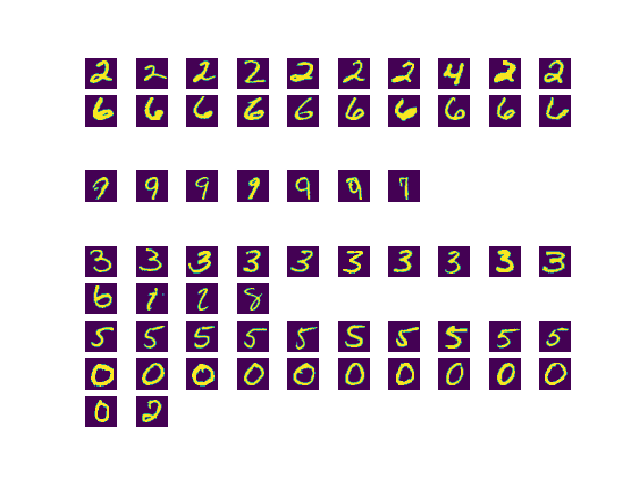

In [8]:
# y_np4 =sess.run(y_4, feed_dict={x: mnist.test.images[:TEST_BATCH_SIZE,]})

# Choose 10 random neurons from 1024 neurons of 4th layer
random_neuron = np.random.choice(1024, size=10, replace=False)
print('Selected Neuron:', random_neuron)

# For 10 images for 10 classes
class_dict = dict()
for c in range(10):
    class_dict[c]=[]
    
# For image predicted class (image_index, probability)
for r in range(y_np4.shape[0]):
    key = np.argmax(y_np4[r][random_neuron])
    class_dict[key].append( (r, np.amax(y_np4[r][random_neuron]) ) )
    
for t in range(10):
    class_dict[t].sort(key=itemgetter(1),reverse=True)
    if len(class_dict[t]) > 10:
        class_dict[t] = class_dict[t][0:10]
        
    # For each class, (image_index, probability)
    # print(x, class_dict[x])


# 10-by-10 image grid
%matplotlib notebook
plt.figure()

c=0
for key in range(10):
    i=0
    for elem in class_dict[key]:
        plt.subplot(10,10,(c*10+i)+1)
        plt.imshow( mnist.test.images[int(elem[0])].reshape((28,28)) )
        plt.axis('off')
        plt.show()
        i +=1
    c+=1

### Apply (tSNE+PCA) to plot in 2D (Q5, Q6)
Q6-> By doing so, you can examine if your data is easy to classify or not. Do you think this raw image samples are easy to classify?

In [9]:
# Get a new train batch
batch_xs, batch_ys = mnist.train.next_batch(TRAIN_BATCH_SIZE)
batch_ys = np.argmax(batch_ys, axis=1)

# First using PCA, we minimize the dimention to 50
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(batch_xs)

# Then using tSNE, we minimize the dimention to 2
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result_50)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.002s...
[t-SNE] Computed neighbors for 1000 samples in 0.207s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.722392
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.020378
[t-SNE] Error after 300 iterations: 1.224079


In [10]:
# Separate 2D point array for each class
points_0,points_1,points_2,points_3,points_4 = None, None,None, None,None
points_5,points_6,points_7,points_8,points_9 = None, None,None, None,None

for i,b in enumerate(batch_ys):
    if b ==0:
        points_0 = np.array( [ tsne_pca_results[i,:] ] ) if points_0 is None else np.concatenate( (points_0, [tsne_pca_results[i,:]]),axis=0 )
    elif b == 1:
        points_1 = np.array( [ tsne_pca_results[i,:] ] ) if points_1 is None else np.concatenate( (points_1, [tsne_pca_results[i,:]]),axis=0 )
    elif b == 2:
        points_2 = np.array( [ tsne_pca_results[i,:] ] ) if points_2 is None else np.concatenate( (points_2, [tsne_pca_results[i,:]]),axis=0 )
    elif b == 3:
        points_3 = np.array( [ tsne_pca_results[i,:] ] ) if points_3 is None else np.concatenate( (points_3, [tsne_pca_results[i,:]]),axis=0 )
    elif b == 4:
        points_4 = np.array( [ tsne_pca_results[i,:] ] ) if points_4 is None else np.concatenate( (points_4, [tsne_pca_results[i,:]]),axis=0 )
    elif b == 5:
        points_5 = np.array( [ tsne_pca_results[i,:] ] ) if points_5 is None else np.concatenate( (points_5, [tsne_pca_results[i,:]]),axis=0 )
    elif b == 6:
        points_6 = np.array( [ tsne_pca_results[i,:] ] ) if points_6 is None else np.concatenate( (points_6, [tsne_pca_results[i,:]]),axis=0 )
    elif b == 7:
        points_7 = np.array( [ tsne_pca_results[i,:] ] ) if points_7 is None else np.concatenate( (points_7, [tsne_pca_results[i,:]]),axis=0 )
    elif b == 8:
        points_8 = np.array( [ tsne_pca_results[i,:] ] ) if points_8 is None else np.concatenate( (points_8, [tsne_pca_results[i,:]]),axis=0 )
    elif b == 9:
        points_9 = np.array( [ tsne_pca_results[i,:] ] ) if points_9 is None else np.concatenate( (points_9, [tsne_pca_results[i,:]]),axis=0 )

        
# mean for each 10 classes        
mean = np.array( [np.mean(points_0, axis=0)] )
mean = np.concatenate( (mean,np.array([np.mean(points_1, axis=0)]),np.array([np.mean(points_2, axis=0)]) ) ,axis=0)
mean = np.concatenate( (mean,np.array([np.mean(points_3, axis=0)]),np.array([np.mean(points_4, axis=0)]) ) ,axis=0)
mean = np.concatenate( (mean,np.array([np.mean(points_5, axis=0)]),np.array([np.mean(points_6, axis=0)]) ) ,axis=0)
mean = np.concatenate( (mean,np.array([np.mean(points_7, axis=0)]),np.array([np.mean(points_8, axis=0)]) ) ,axis=0)
mean = np.concatenate( (mean,np.array([np.mean(points_9, axis=0)]) ) ,axis=0)
print("Means:\n",mean)

Means:
 [[-6.6294227   7.711112  ]
 [-0.8946762  -9.264636  ]
 [-3.693075   -3.9626026 ]
 [-7.7433205   3.949633  ]
 [10.95549    -4.3462296 ]
 [-2.3807077   4.053698  ]
 [ 2.1929927   9.347339  ]
 [10.132171   -0.02559382]
 [-9.976614   -1.2551479 ]
 [ 9.857113   -3.2280858 ]]


<IPython.core.display.Javascript object>


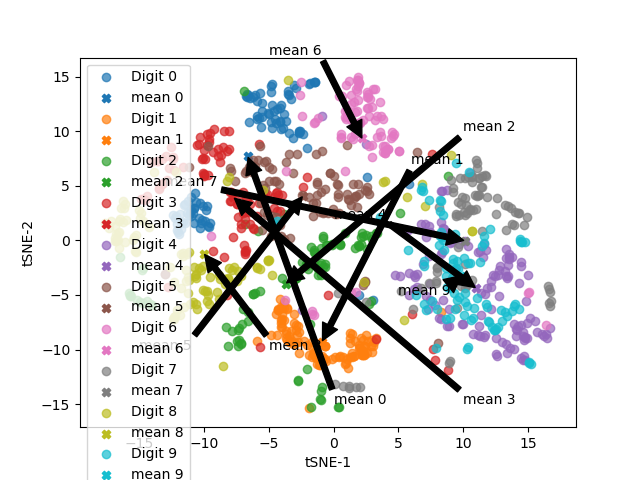

In [11]:
# Color code for 10 class
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

%matplotlib notebook
plt.figure()

plt.scatter(points_0[:,0], points_0[:,1], c=colors[0] , alpha=0.7, label='Digit 0')
# plt.scatter(mean[0,0],mean[0,1], c=colors[0], alpha=1, marker=r" mean0 ", label='mean 0')
plt.scatter(mean[0,0],mean[0,1], c=colors[0], alpha=1,marker='X', label='mean 0')
plt.annotate('mean 0', xy=( mean[0,0],mean[0,1] ), xytext=(0, -15),
            arrowprops=dict(facecolor='black', shrink=0.005),
            )

plt.scatter(points_1[:,0], points_1[:,1], c = colors[1] , alpha=0.7, label='Digit 1')
# plt.scatter(mean[1,0],mean[1,1], c=colors[1], alpha=1, marker=r'$mean1$', label='mean 1')
plt.scatter(mean[1,0],mean[1,1], c=colors[1], alpha=1,marker='X', label='mean 1')
plt.annotate('mean 1', xy=( mean[1,0],mean[1,1] ), xytext=(6, 7),
            arrowprops=dict(facecolor='black', shrink=0.005),
            )

plt.scatter(points_2[:,0], points_2[:,1], c = colors[2] , alpha=0.7, label='Digit 2')
# plt.scatter(mean[2,0],mean[2,1], c=colors[2], alpha=1, marker=r'$mean2$', label='mean 2')
plt.scatter(mean[2,0],mean[2,1], c=colors[2], alpha=1,marker='X', label='mean 2')
plt.annotate('mean 2', xy=( mean[2,0],mean[2,1] ), xytext=(10, 10),
            arrowprops=dict(facecolor='black', shrink=0.005),
            )

plt.scatter(points_3[:,0], points_3[:,1], c = colors[3] , alpha=0.7, label='Digit 3')
# plt.scatter(mean[3,0],mean[3,1], c=colors[3], alpha=1,marker=r'$mean3$', label='mean 3')
plt.scatter(mean[3,0],mean[3,1], c=colors[3], alpha=1,marker='X', label='mean 3')
plt.annotate('mean 3', xy=( mean[3,0],mean[3,1] ), xytext=(10, -15),
            arrowprops=dict(facecolor='black', shrink=0.005),
            )

plt.scatter(points_4[:,0], points_4[:,1], c = colors[4] , alpha=0.7, label='Digit 4')
# plt.scatter(mean[4,0],mean[4,1], c=colors[4], alpha=1,marker=r'$mean4$', label='mean 4')
plt.scatter(mean[4,0],mean[4,1], c=colors[4], alpha=1,marker='X', label='mean 4')
plt.annotate('mean 4', xy=( mean[4,0],mean[4,1] ), xytext=(0, 2),
            arrowprops=dict(facecolor='black', shrink=0.005),
            )

plt.scatter(points_5[:,0], points_5[:,1], c = colors[5] , alpha=0.7, label='Digit 5')
# plt.scatter(mean[5,0],mean[5,1], c=colors[5], alpha=1, marker=r'$mean5$', label='mean 5')
plt.scatter(mean[5,0],mean[5,1], c=colors[5], alpha=1,marker='X', label='mean 5')
plt.annotate('mean 5', xy=( mean[5,0],mean[5,1] ), xytext=(-15, -10),
            arrowprops=dict(facecolor='black', shrink=0.005),
            )

plt.scatter(points_6[:,0], points_6[:,1], c = colors[6] , alpha=0.7, label='Digit 6')
# plt.scatter(mean[6,0],mean[6,1], c=colors[6], alpha=1,marker=r'$mean6$', label='mean 6')
plt.scatter(mean[6,0],mean[6,1], c=colors[6], alpha=1,marker='X', label='mean 6')
plt.annotate('mean 6', xy=( mean[6,0],mean[6,1] ), xytext=(-5, 17),
            arrowprops=dict(facecolor='black', shrink=0.005),
            )

plt.scatter(points_7[:,0], points_7[:,1], c = colors[7] , alpha=0.7, label='Digit 7')
# plt.scatter(mean[7,0],mean[7,1], c=colors[7], alpha=1,marker=r'$mean7$', label='mean 7')
plt.scatter(mean[7,0],mean[7,1], c=colors[7], alpha=1,marker='X', label='mean 7')
plt.annotate('mean 7', xy=( mean[7,0],mean[7,1] ), xytext=(-13, 5),
            arrowprops=dict(facecolor='black', shrink=0.005),
            )

plt.scatter(points_8[:,0], points_8[:,1], c = colors[8] , alpha=0.7, label='Digit 8')
# plt.scatter(mean[8,0],mean[8,1], c=colors[8], alpha=1,marker=r'$mean8$', label='mean 8')
plt.scatter(mean[8,0],mean[8,1], c=colors[8], alpha=1,marker='X', label='mean 8')
plt.annotate('mean 8', xy=( mean[8,0],mean[8,1] ), xytext=(-5, -10),
            arrowprops=dict(facecolor='black', shrink=0.005),
            )

plt.scatter(points_9[:,0], points_9[:,1], c = colors[9] , alpha=0.7, label='Digit 9')
# plt.scatter(mean[9,0],mean[9,1], c=colors[9], alpha=1,marker=r'$mean9$', label='mean 9')
plt.scatter(mean[9,0],mean[9,1], c=colors[9], alpha=1,marker='X', label='mean 9')
plt.annotate('mean 9', xy=( mean[9,0],mean[9,1] ), xytext=(5, -5),
            arrowprops=dict(facecolor='black', shrink=0.005),
            )

plt.xlabel("tSNE-1")
plt.ylabel("tSNE-2")
plt.legend(loc=0)
plt.show()


### tSNE+PCA for all layer (Q7, Q8)
Q7-> What that means is that you transformed your input data into a 1024-dim space. You may hope that this makes your classification easier.

Q8-> Explain your observation.

In [13]:
# Take softmax of output for each layer
y_est_1 = tf.nn.softmax(y_1)
y_est_2 = tf.nn.softmax(y_2)
y_est_3 = tf.nn.softmax(y_3)
y_est_4 = tf.nn.softmax(y_4)
y_est_5 = tf.nn.softmax(y)

# Get a new train batch
batch_xs, batch_ys = mnist.test.next_batch(TEST_BATCH_SIZE)

y_np5,y_np4,y_np3,y_np2,y_np1 =sess.run([y_est_5,y_est_4,y_est_3,y_est_2,y_est_1], 
                                          feed_dict={x: batch_xs})

batch_ys = np.argmax(batch_ys, axis=1)


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.002s...
[t-SNE] Computed neighbors for 1000 samples in 0.145s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.002359
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.255814
[t-SNE] Error after 300 iterations: 0.769585


<IPython.core.display.Javascript object>


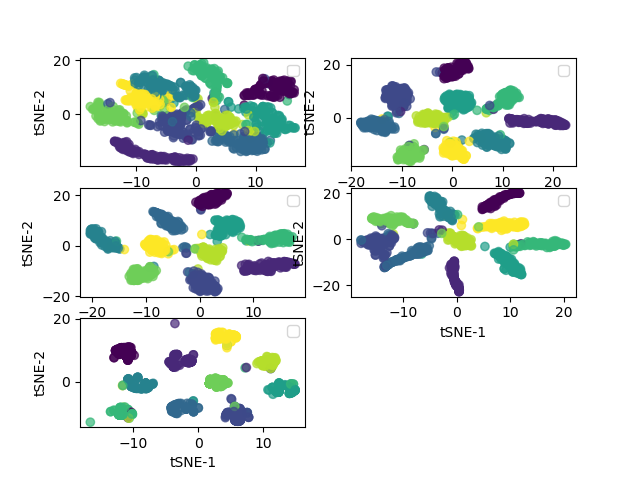

No handles with labels found to put in legend.


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.002s...
[t-SNE] Computed neighbors for 1000 samples in 0.132s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.002537
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.700726


No handles with labels found to put in legend.


[t-SNE] Error after 300 iterations: 0.512730
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.117s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.004604
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.189247


No handles with labels found to put in legend.


[t-SNE] Error after 300 iterations: 0.412597
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.114s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.017088
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.401711


No handles with labels found to put in legend.


[t-SNE] Error after 300 iterations: 0.346847
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.026s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 39.011700


No handles with labels found to put in legend.


[t-SNE] Error after 300 iterations: 0.288083


In [14]:
## For 1st Layer
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(y_np1)

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result_50)


%matplotlib notebook
plt.figure()

plt.subplot(3,2,1)
plt.scatter(tsne_pca_results[:,0], tsne_pca_results[:,1], c=batch_ys, alpha=0.7)
plt.xlabel("tSNE-1")
plt.ylabel("tSNE-2")
plt.legend()
plt.show()


## For 2nd Layer
pca_result_50 = pca_50.fit_transform(y_np2)
tsne_pca_results = tsne.fit_transform(pca_result_50)

# %matplotlib notebook
# plt.figure()
plt.subplot(3,2,2) 
plt.scatter(tsne_pca_results[:,0], tsne_pca_results[:,1], c=batch_ys, alpha=0.7)
plt.xlabel("tSNE-1")
plt.ylabel("tSNE-2")
plt.legend()
plt.show()


## For 3rd Layer
pca_result_50 = pca_50.fit_transform(y_np3)
tsne_pca_results = tsne.fit_transform(pca_result_50)

# %matplotlib notebook
# plt.figure()
plt.subplot(3,2,3) 
plt.scatter(tsne_pca_results[:,0], tsne_pca_results[:,1], c=batch_ys, alpha=0.7)
plt.xlabel("tSNE-1")
plt.ylabel("tSNE-2")
plt.legend()
plt.show()


## For 4th Layer
pca_result_50 = pca_50.fit_transform(y_np4)
tsne_pca_results = tsne.fit_transform(pca_result_50)

# %matplotlib notebook
# plt.figure()
plt.subplot(3,2,4)     
plt.scatter(tsne_pca_results[:,0], tsne_pca_results[:,1], c=batch_ys, alpha=0.7)
plt.xlabel("tSNE-1")
plt.ylabel("tSNE-2")
plt.legend()
plt.show()



## For 5th Layer
pca_5 = PCA(n_components=5)
pca_result_5 = pca_5.fit_transform(y_np5)
tsne_pca_results = tsne.fit_transform(pca_result_5)

# %matplotlib notebook
# plt.figure()
plt.subplot(3,2,5)
plt.scatter(tsne_pca_results[:,0], tsne_pca_results[:,1], c=batch_ys, alpha=0.7)
plt.xlabel("tSNE-1")
plt.ylabel("tSNE-2")
plt.legend()
plt.show()